In [1]:
'''Script to examine associahedra/exchange-graph structure
...to do:
    ~ Streamline EG function (function argument st only save needed seeds)
    ~ learn: f polynomials, greedy element
    ~ take finite-mutation type quiver, find associahedra, define this as a quiver (using unique associaehdra orientation?), find associahedra, etc...

Questions: 
~ can mutation of a cluster reproduce same cluster, i.e are all exchange graphs loop free? (assume loop-free)
~ can mutating the same cluster about two different variables produce the same cluster, i.e. all cluster EG edges multiplicity 1? (assume no)
...note that the same quiver mutated at two different nodes can each produce the same different quiver, i.e. multiple edges exist in quiver EG but we are collecting them into 1
~ correct to consider up_to_equivalence False? i.e. same cluster variables in different order are different clusters (assume yes)

Notes: ...using https://arxiv.org/pdf/1102.4844.pdf
Max number of seeds in class to each depth = n*(n-1)^(depth-1) ~ (n-1)^depth for initial seed with n variables
All cluster variables are Laurent polynomials with positive coefficients
mutation_class(): the up_to_equivalence if false will count all non-identical quivers and if true will count all non-isomorphic quivers (i.e two quivers with the same structure but different vertex labelling are considered equivalent but not identical) --> so interested in up_to_equivalence false
cluster variables = free variabels = mutable variables
frozen variables = coefficients = non-mutable varaibles (note mutation will mix these variables in with the free ones, as a quiver they are still vertices)
principle extension adds a rank n identity matrix onto end of the b matrix (conversely principle restriction removes the frozen variables), the identity matrix then introduces a frozen vertex attached to each original cluster variable vertex
quiver is 'bipartite' if every vertex is either a sink or source
Number of exchange matrices for affine finite-mutation type given p30 https://arxiv.org/pdf/1102.4844.pdf
Cluster complex has vertices as cluster variables and facets as clusters
c_vector(k) => kth column vector of bottom of matrix (frozen part)
g_vector(k) => set all frozen variables to zero in cluster, for cluster variable k list the degree that the initial cluster variables appear in it (i.e. x_2 --> (x_0+y_0)/x_2 => g_vector(2) = (1,0,-1))
d_vector(k) => degree of each initial cluster variable in the denominator of the new kth cluster variable considered (if no denom then set to -1 in the variables in numerator)
c/d/g_matrix => vectors for all k as columns
A vertex is green/red if c-vector has all non-positive/non-negative entries, i.e a free vertex is a sink/source wrt frozen vertices (ignoring connections to free ones)
'''

#Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx #...this has large overhead so makes looking at high depths very slow


In [2]:
#Exchange Graph function for cluster mutation
#...to do: add input functionality to only save current seeds for checking (better memory storage), include frozen vertices, do with up_to_equivalence True
def ExchangeGraph(init_seed,depth,print_check=True):  #...input inital seed as a ClusterSeed(), and the max depth to mutate to
    #Output initial seed and save number of cluster variables (i.e. nodes)
    if print_check: print('Initial_seed: '+str(init_seed)+'\n')
    n = init_seed.n()                #...extract number of mutable variables
    #Initialise EG and lists to keep track of all seeds, those requiring mutation, and indices of those to check against in previous 2 depths
    EG = nx.empty_graph()            #...define the exchange graph
    EG.add_node(0)                   #...add node corresponding to initial seed
    seed_list, current_seeds, next_seeds, checkable_seeds = [init_seed], [], [[init_seed,0,-1]], [0,0]
    if print_check: print('Progress report:\n{:<14}  {:<20}  {:<20}'.format('Depth: 0,', '# new seeds: -', '# total seeds: '+str(len(seed_list)))) #...output mutation updates
    #Mutate initial seed to specified depth
    for d in range(1,depth+1):
        #Update the current seeds to mutate, and the seeds in previous 2 depths to check against
        current_seeds = next_seeds
        next_seeds = []
        checkable_seeds[0] = checkable_seeds[1]                #...update list position of start of 2 depths ago (only need to check these for equivalence)
        checkable_seeds[1] = len(seed_list)-len(current_seeds) #...save end of last depth position for next iteration
        #Loop through the current seeds, mutating all their other variables
        for seed_info in current_seeds:
            #Identify the nodes to mutate about (if first depth then mutate them all)
            if d == 1: variable_list = list(range(n))
            else: variable_list = list(range(n))[:seed_info[2]]+list(range(n))[seed_info[2]+1:] #...skip last vertex mutated about
            #Mutate about all nodes not previously mutated about
            for variable in variable_list: 
                new_seed = seed_info[0].mutate(variable,inplace=False)
                new_test = True              #...boolean to verify if the generated seed is new
                #Loop through all previous depth and new seeds in EG, check if the new seed matches any of them, if so add edge from current seed, otherwise add as a new node & edge
                for idx, old_seed in enumerate(seed_list[checkable_seeds[0]:]): #...idx gives the seeds label in EG, note includes checking where 2 mutations of a seed produce the same seed
                    if old_seed == new_seed: #...only checks NOT up to equivalence (i.e no shuffling cluster variables)
                        new_test = False     #...note that the generated seed is a repeat
                        #If edge already in EG, add extra mutation label if relevant (i.e. not already in label's list)
                        if EG.has_edge(min(seed_info[1],idx+checkable_seeds[0]),max(seed_info[1],idx+checkable_seeds[0])):
                            if variable not in list(nx.get_edge_attributes(EG,'label')[min(seed_info[1],idx+checkable_seeds[0]),max(seed_info[1],idx+checkable_seeds[0])]):
                                #Where edge already in EG and label needs updatng to include new mutable node, remove old edge (required otherwise nx overlaps), then readd edge with updated label
                                new_label = [*list(nx.get_edge_attributes(EG,'label')[min(seed_info[1],idx+checkable_seeds[0]),max(seed_info[1],idx+checkable_seeds[0])]),variable]
                                EG.remove_edge(min(seed_info[1],idx+checkable_seeds[0]),max(seed_info[1],idx+checkable_seeds[0]))
                                EG.add_edge(min(seed_info[1],idx+checkable_seeds[0]),max(seed_info[1],idx+checkable_seeds[0]),label=new_label)
                        #Add new edge involving old nodes
                        else: 
                            EG.add_edge(min(seed_info[1],idx+checkable_seeds[0]),max(seed_info[1],idx+checkable_seeds[0]),label=[variable]) #...add edge connecting to relevant seed
                        break   
                if new_test:
                    seed_list.append(new_seed)
                    next_seeds.append([new_seed,len(seed_list)-1,variable]) #...save new seed to mutate, the seed's label in the EG, and the cluster variable to not mutate in next iteration
                    EG.add_edge(seed_info[1],len(seed_list)-1,label=[variable])              #...add new node, connected to mutated seed
        if print_check: print('{:<14}  {:<20}  {:<20}'.format('Depth: '+str(d)+',', '# new seeds: '+str(len(next_seeds))+',', '# total seeds: '+str(len(seed_list)))) #...output mutation updates
        #Check if any new seeds were generated at this depth, otherwise terminate loop
        if len(next_seeds) == 0:
            if print_check:
                try: init_seed.cluster(); print('\n...early termination, no new seeds found at depth:',d,'--> finite type') #...if input is a cluster then must be finite type
                except: print('\n...early termination, no new seeds found at depth:',d,'--> finite-mutation type') #...if input is a quiver then may just be finite-mutation type
            break
            
    return [EG,seed_list] #...note the EG vertex labelling matches indices in the returned seed_list


In [59]:
#Exchange Graph Analysis
#A4vsD4 (fin,fin), A4vsA13 (fin,finmut), F4vsinf1 (fin,inf), A13vsA22 (finmut,finmut), A13vsinf1 (finmut,inf), inf1vsinf2 (inf,inf)
G = ClusterSeed(['A',[2,2],1]).quiver()
#G = ClusterSeed(matrix([[0,2,0,0],[-2,0,1,0],[0,-1,0,1],[0,0,-1,0]])).quiver() #inf1
#G = ClusterSeed(matrix([[0,2,0,-2],[-2,0,2,0],[0,-2,0,1],[2,0,-1,0]])).quiver() #inf2
#G = ClusterSeed(matrix([[0,1,0,0],[-1,0,1,0],[0,-1,0,1],[0,0,-1,0]])) #A4 different orientation

#G.show()                  
#print('Type estimates: ',G.is_finite(),G.is_mutation_finite(),'\n',G.b_matrix())
G_EG = ExchangeGraph(G, 4, True)

from math import comb
print('Density:',nx.density(G_EG[0]),'for',len(G_EG[0]),'nodes')
print('Clustering (triangle,square):','('+str(sum(nx.clustering(G_EG[0]).values())/float(len(G_EG[0])))+','+str(sum(nx.square_clustering(G_EG[0]).values())/float(len(G_EG[0])))+')')
WIndex = nx.wiener_index(G_EG[0])
print('Wiener index:',WIndex,'(normalised:',WIndex/comb(len(G_EG[0]),2),')')
EVCentrality = nx.eigenvector_centrality(G_EG[0],max_iter=1000)
max_EVC = max(EVCentrality, key=EVCentrality.get)
print('Centrality:',max_EVC)
print('...centrality range:',max(EVCentrality.values())-min(EVCentrality.values()))
if max_EVC == 0: print('...depth-step centrality change:',EVCentrality[0]-max([EVCentrality[i] for i in range(1,5)]))
#print(EVCentrality)
cycle_basis = nx.minimum_cycle_basis(G_EG[0])
cycle_lengths, freqs = np.unique(np.array(list(map(len,cycle_basis))), return_counts=True)
print('Cycle basis info (cycle length, frequency):\n',np.asarray((cycle_lengths, freqs)).T)
#print(EVCentrality)


Initial_seed: Quiver on 4 vertices of type ['A', [2, 2], 1]

Progress report:
Depth: 0,       # new seeds: -        # total seeds: 1    
Depth: 1,       # new seeds: 4,       # total seeds: 5    
Depth: 2,       # new seeds: 9,       # total seeds: 14   
Depth: 3,       # new seeds: 20,      # total seeds: 34   
Depth: 4,       # new seeds: 16,      # total seeds: 50   
Density: 0.06693877551020408 for 50 nodes
Clustering (triangle,square): (0.07999999999999996,0.10790476190476196)
Wiener index: 4780.0 (normalised: 3.9020408163265308 )
Centrality: 0
...centrality range: 0.2156957007864349
...depth-step centrality change: 0.028635576611952096
Cycle basis info (cycle length, frequency):
 [[ 3  8]
 [ 4 15]
 [ 7  2]
 [ 8  8]]


In [63]:
for c in cycle_basis:
    if len(c)==3: print(c)

[5, 14, 15]
[17, 18, 7]
[19, 21, 8]
[22, 23, 9]
[24, 25, 10]
[11, 27, 28]
[12, 29, 31]
[32, 33, 13]


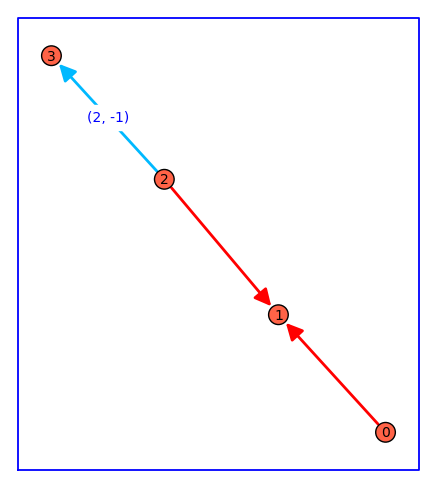

Type estimates:  True True 


Number of seeds: 42
EG degree frequency distribution: [0, 16, 4, 0, 22]


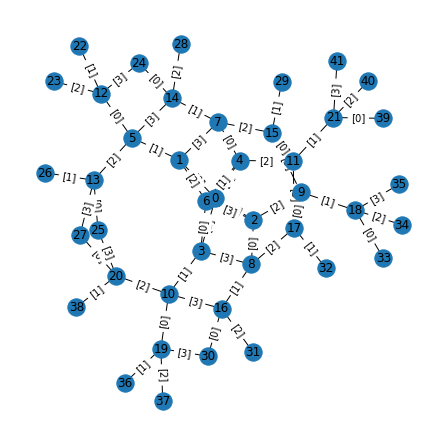

In [30]:
#Output EG with mutation labels
#Define and output seed information
G = ClusterSeed(['C',4]).quiver() #...choose seed (cluster or quiver)
#G = ClusterSeed(matrix([[0,2,0,0],[-2,0,1,0],[0,-1,0,1],[0,0,-1,0]])).quiver()
G.show() #...plot quiver
#G.save_image('./__quiver.pdf')
print('Type estimates: ',G.is_finite(),G.is_mutation_finite(),'\n') #...output finiteness estimates

#Compute exchange graph
G_EG = ExchangeGraph(G,4,False)
#Choose a cycle to output clusters for
#cycle_to_output = [0,1,6,3]
#for seed in cycle_to_output: print('Seed: '+str(seed)+', Cluster: '+str(G_EG[1][seed].cluster()))
    
#Draw the EG with edges labelled
if len(G_EG[1]) < 100: 
    pos=nx.kamada_kawai_layout(G_EG[0])
    plt.figure('EG',figsize=(6,6)) 
    nx.draw(G_EG[0],pos,with_labels=True)     #...draw EG if suitably small
    nx.draw_networkx_edge_labels(G_EG[0],pos,edge_labels=nx.get_edge_attributes(G_EG[0],'label'),label_pos=0.5)     #...draw EG if suitably small
    plt.savefig('./I1quiv.pdf')
    print('\nNumber of seeds:',len(G_EG[1]))
print('EG degree frequency distribution:',nx.degree_histogram(G_EG[0]))



Initial_seed: A seed for a cluster algebra of rank 4 of type ['D', 4]
B-matrix:
[ 0  1  0  0]
[-1  0 -1 -1]
[ 0  1  0  0]
[ 0  1  0  0]

Quiver EG seeds highlighted: [0, 2, 7, 4] --> ['red', 'blue', 'orange', 'green']


"\n#Output the quivers and clusters in the cycle\nprint(np.array([quivers[q_idx].b_matrix() for q_idx in quivers_to_colour]),end='\n\n')\nfor q_clustslist in coloured_clusts: \n    for clust in q_clustslist:\n        print(clust)\n    print('')\n"

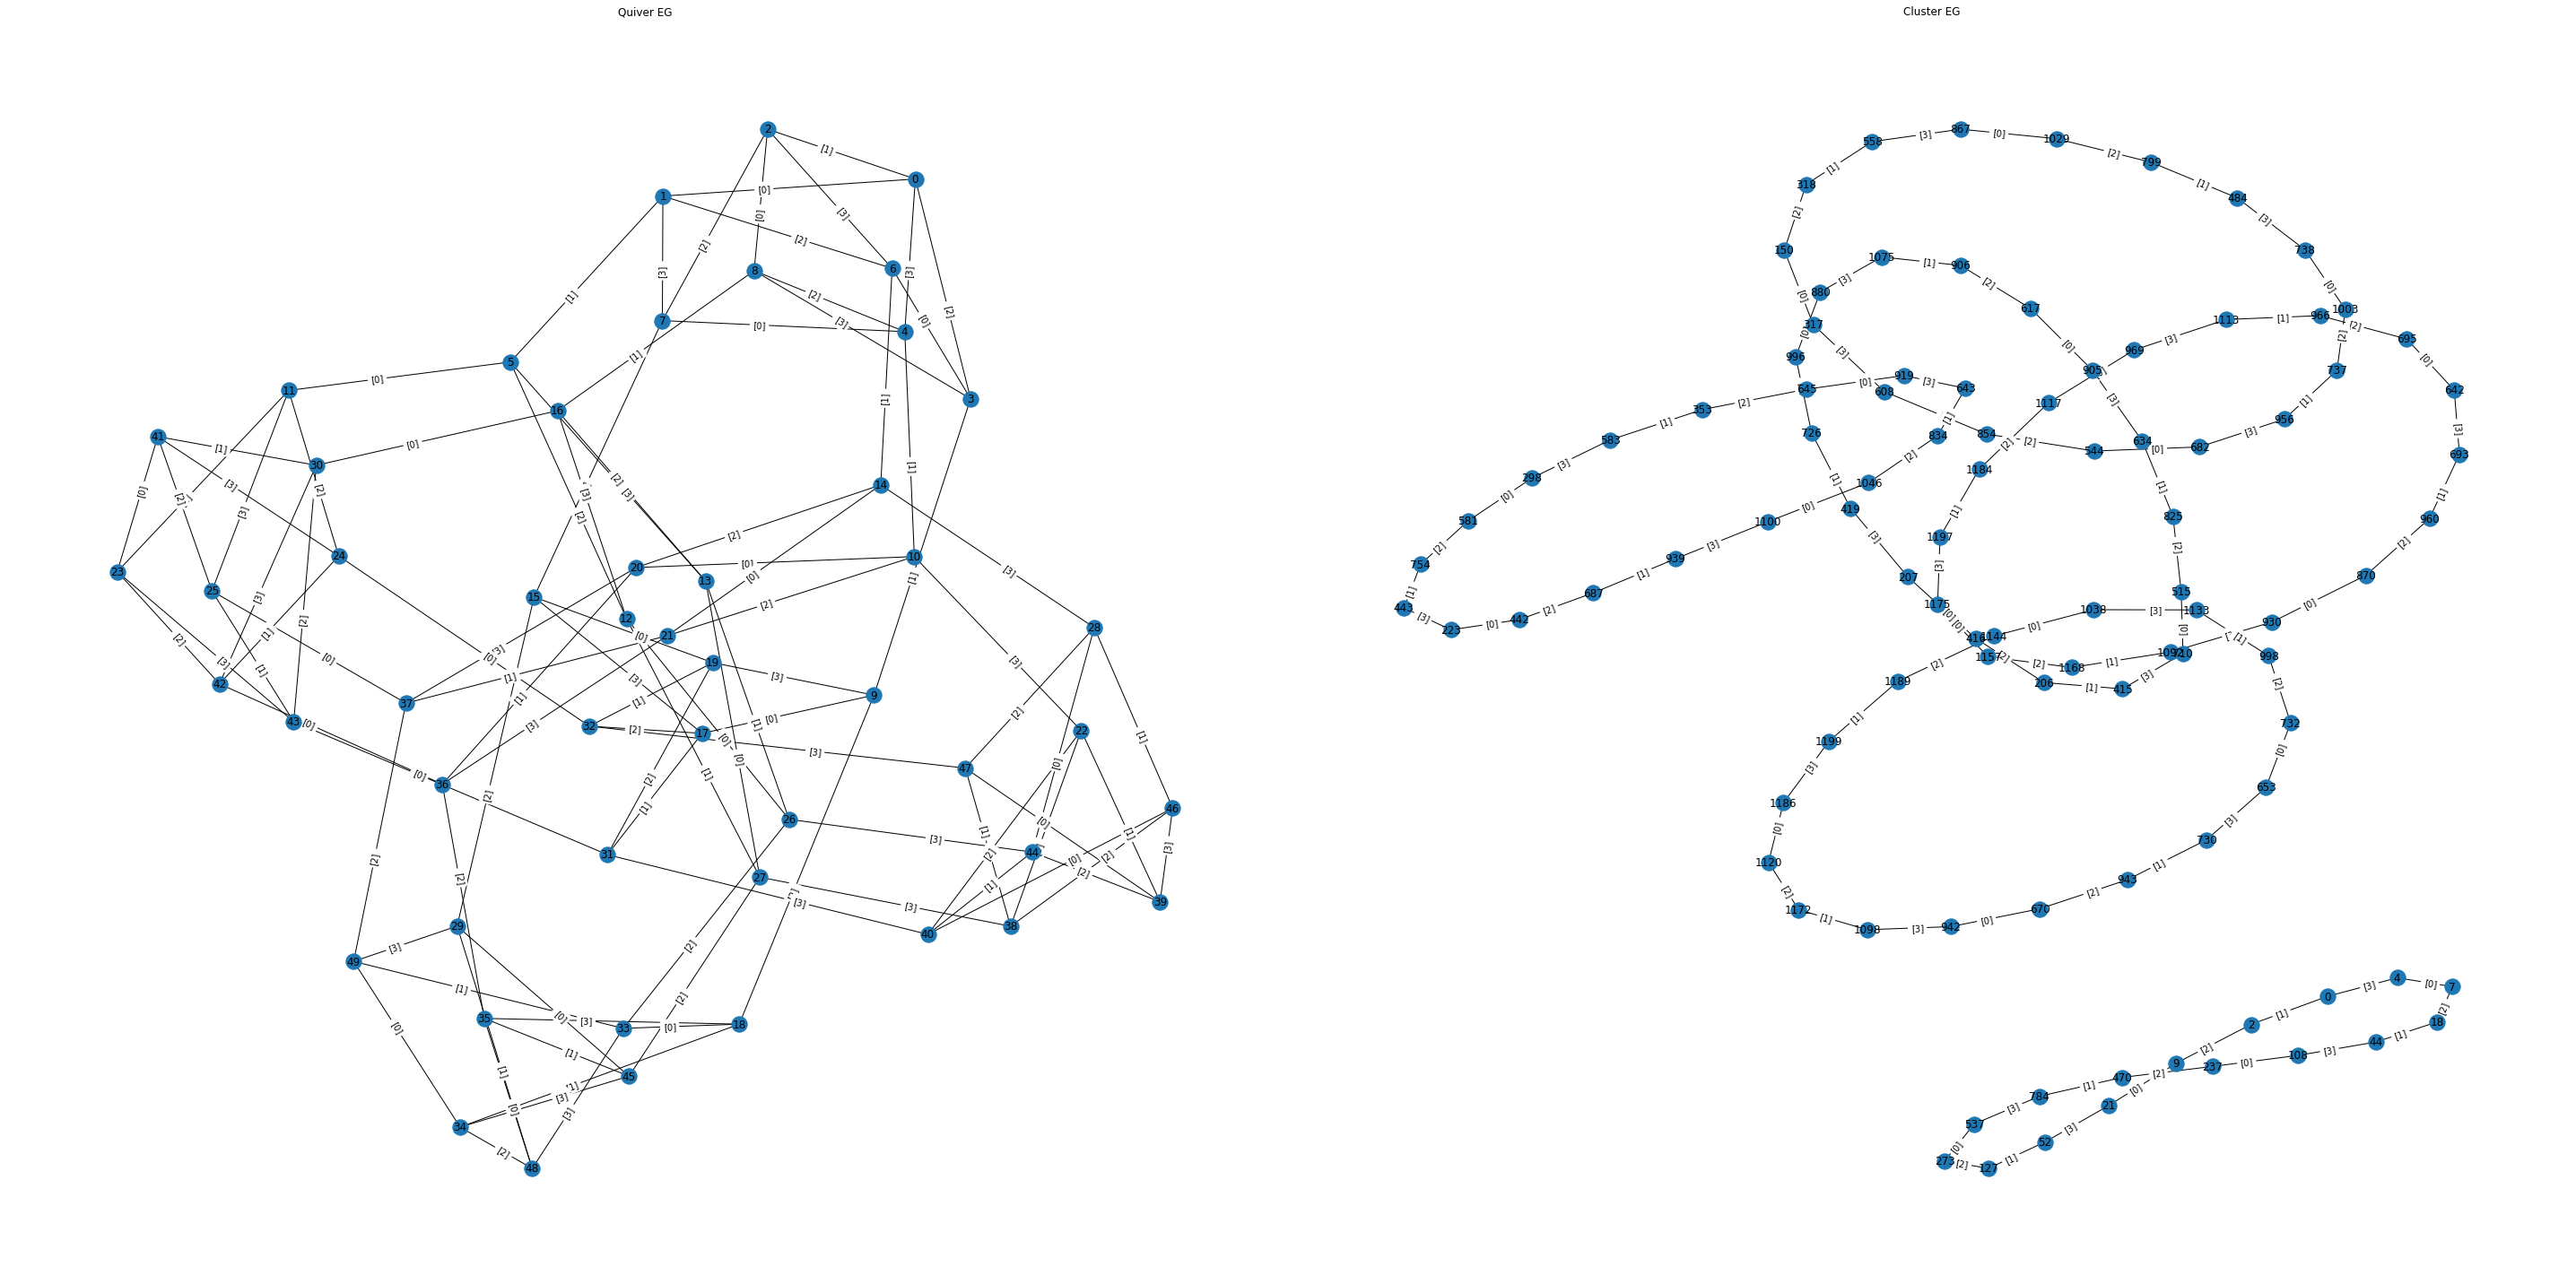

In [34]:
#Plot Cluster EG with nodes coloured st all those with the same colour have the same quiver
#...can select so all coloured or selection (eg a cycle) coloured
#Define variables to run with
cycle_subgraph = 1        #...choose whether to output full EG or just subgraph corresponding to selected quivers_to_colour (usually a cycle)
use_quiver_EG = 1         #...choose whether to also output the quiver EG
all_coloured_check = False   #...choose whether to colour all the different quiver differently (True), or one quiver of choice (False)
quivers_to_colour = [0,2,7,4]         #...if only colour one quiver, choose which in quiver list will be coloured
preset_colours = ['red','blue','orange','green','yellow','purple','gray','brown'] #...some example colours

#Define initial seed and its EG
depth = 20
G = ClusterSeed(['D',4]) #A22 3-cycle: [5,14,15]
#G = ClusterSeed(matrix([[0,2,0,0],[-2,0,1,0],[0,-1,0,1],[0,0,-1,0]])) #inf1
#G = ClusterSeed(matrix([[0,2,0,-2],[-2,0,2,0],[0,-2,0,1],[2,0,-1,0]])) #inf2
#G.show()
G_EG = ExchangeGraph(G, depth, False)          #...compute exchange graph

#If wish to use Quiver EG, compute it and save its quivers to compare to
if use_quiver_EG: 
    Quiv_EG = ExchangeGraph(G.quiver(), depth, False)
    quivers = Quiv_EG[1]
else: quivers = []

#Allocate clusters an integer based on the quiver they're related to (integer will relate to the colour in the colour_map)
seed_colours = []
for seed in G_EG[1]:
    if seed.quiver() in quivers:
        seed_colours.append(quivers.index(seed.quiver()))
    else:
        if use_quiver_EG: print('Error: clusters quiver not in Quiv_EG')
        quivers.append(seed.quiver())
        if len(seed_colours) == 0: seed_colours.append(0)
        else: seed_colours.append(max(seed_colours)+1)

if all_coloured_check:
    #Normalise the colour map and then plot
    low, *_, high = sorted(seed_colours)
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
    colour_map = [mapper.to_rgba(i) for i in seed_colours]
    #...note the darker colours are lower integers in list, which are then quivers found earlier in the checking, st they are roughly quivers closer to the EG centre
else:
    colour_map = []
    coloured_clusts = [[] for i in quivers_to_colour]
    for seed_idx, colour_idx in enumerate(seed_colours):
        if colour_idx in quivers_to_colour: 
            colour_map.append(preset_colours[quivers_to_colour.index(colour_idx)])
            coloured_clusts[quivers_to_colour.index(colour_idx)].append([seed_idx,G_EG[1][seed_idx].cluster()])
        else: colour_map.append('black')

#Output the figures
print('Initial_seed: '+str(G_EG[1][0])+'\nB-matrix:\n'+str(G_EG[1][0].b_matrix()))
if use_quiver_EG:
    if not all_coloured_check: print('\nQuiver EG seeds highlighted:',quivers_to_colour,'-->',preset_colours[:len(quivers_to_colour)])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))
    Qpos = nx.kamada_kawai_layout(Quiv_EG[0])
    nx.draw(Quiv_EG[0], Qpos, with_labels=True, ax=axes[0]) #...output Quiver EG for comparison
    nx.draw_networkx_edge_labels(Quiv_EG[0],Qpos,edge_labels=nx.get_edge_attributes(Quiv_EG[0],'label'),label_pos=0.4, ax=axes[0])
    if cycle_subgraph: 
        cycle_sub = G_EG[0].subgraph([clust[0] for colour in coloured_clusts for clust in colour])
        pos=nx.spring_layout(cycle_sub)
        nx.draw(cycle_sub, pos, with_labels=True, ax=axes[1])
        nx.draw_networkx_edge_labels(cycle_sub,pos,edge_labels=nx.get_edge_attributes(cycle_sub,'label'),label_pos=0.4, ax=axes[1])     #...draw EG if suitably small
    else:              nx.draw_kamada_kawai(G_EG[0], with_labels=True, node_color=colour_map, font_color='white', ax=axes[1])
    #nx.draw_kamada_kawai(G_EG[0], with_labels=True, node_color=colour_map, font_color='white', ax=axes[1])
    axes[0].title.set_text('Quiver EG')
    axes[1].title.set_text('Cluster EG')
    fig.tight_layout() 
else: 
    if cycle_subgraph:
        cycle_sub = G_EG[0].subgraph([clust[0] for colour in coloured_clusts for clust in colour])
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        pos=nx.spring_layout(cycle_sub)
        nx.draw(cycle_sub,pos, with_labels=True)
        nx.draw_networkx_edge_labels(cycle_sub,pos,edge_labels=nx.get_edge_attributes(cycle_sub,'label'),label_pos=0.4)     #...draw EG if suitably small
        #nx.draw_spring(cycle_sub, with_labels=True, font_color='black')
        subgraph_cb = nx.minimum_cycle_basis(cycle_sub)
        print('\nSubgraph cycles: (#,lengths) --> ',len(subgraph_cb),list(map(len,subgraph_cb)),'\n',subgraph_cb,'\n') 
    else:   
        nx.draw_kamada_kawai(G_EG[0], with_labels=True, node_color=colour_map, font_color='white')
    #plt.tight_layout()
    #plt.savefig('./A4cycle'+str(quivers_to_colour)+'.pdf')
'''
#Output the quivers and clusters in the cycle
print(np.array([quivers[q_idx].b_matrix() for q_idx in quivers_to_colour]),end='\n\n')
for q_clustslist in coloured_clusts: 
    for clust in q_clustslist:
        print(clust)
    print('')
''' 

In [28]:
#...reprint subgraph info from above cell
p=nx.minimum_cycle_basis(cycle_sub)
print(len(p),list(map(len,p)),'\n',p)

15 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 28] 
 [[0, 1, 3, 6], [0, 2, 4, 10], [779, 595, 772, 907], [227, 595, 398, 399], [17, 18, 6, 41], [50, 22, 25, 10], [90, 41, 186, 93], [337, 338, 532, 186], [963, 965, 871, 1002], [720, 532, 871, 719], [995, 980, 907, 940], [997, 985, 1002, 955], [995, 997, 987, 942], [112, 113, 50, 227], [0, 1, 2, 963, 772, 6, 10, 907, 398, 719, 17, 337, 595, 532, 22, 90, 227, 995, 997, 871, 41, 1002, 940, 942, 112, 50, 186, 955]]


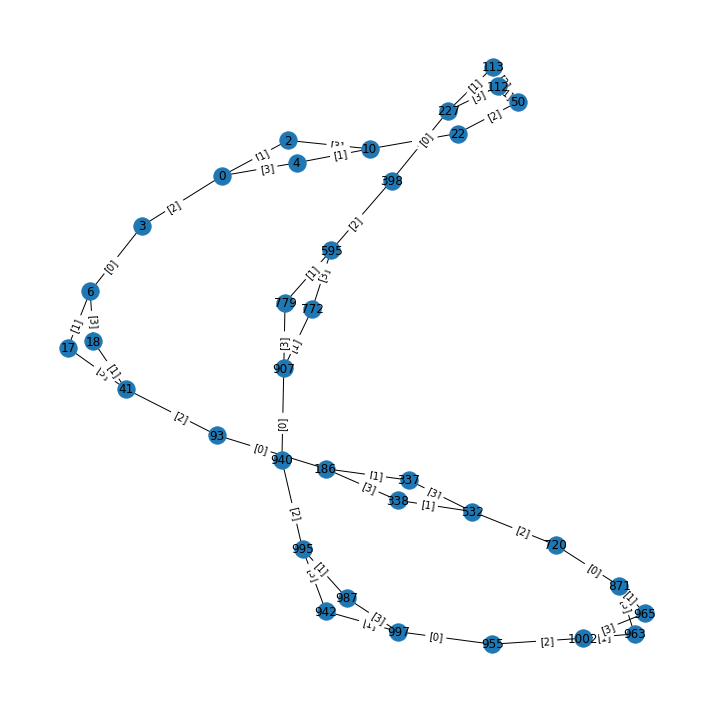

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
pos=nx.spring_layout(cycle_sub)
nx.draw(cycle_sub,pos, with_labels=True)
nx.draw_networkx_edge_labels(cycle_sub,pos,edge_labels=nx.get_edge_attributes(cycle_sub,'label'),label_pos=0.4)     #...draw EG if suitably small
plt.tight_layout()
plt.savefig('./D4cycle'+str(quivers_to_colour)+'.pdf')


In [ ]:
###Running on supercomuter!!
#Compute graph-edit-distance between the Quiver EG and Cluster EG 
max_depth = 2
#init_seeds = [ClusterSeed(['A',4]),ClusterSeed(['D',4]),ClusterSeed(['F',4]),ClusterSeed(['A',[1,3],1]),ClusterSeed(['A',[2,2],1]),ClusterSeed(matrix([[0,2,0,0],[-2,0,1,0],[0,-1,0,1],[0,0,-1,0]])),ClusterSeed(matrix([[0,2,0,-2],[-2,0,2,0],[0,-2,0,1],[2,0,-1,0]]))]
init_seeds = [ClusterSeed(['A',[1,3],1])]
GEDs = []

for seed in init_seeds:
    GEDs.append([])
    for d in [3]: #range(max_depth+1):
        Q_EG = ExchangeGraph(seed.quiver(), d, False)
        G_EG = ExchangeGraph(seed, d, False)  
        GEDs[-1].append(nx.graph_edit_distance(Q_EG[0], G_EG[0], roots=(0,0))) #...match the initial seeds for nx.graph_edit_distance
        print(GEDs)
'''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
nx.draw_kamada_kawai(Q_EG[0], with_labels=False, ax=axes[0]) #...output Quiver EG for comparison
nx.draw_kamada_kawai(G_EG[0], with_labels=False, ax=axes[1])
axes[0].title.set_text('Quiver EG')
axes[1].title.set_text('Cluster EG')
fig.tight_layout() 
'''
    
print(GEDs)

In [ ]:
#Output selected seeds from EG
'''
seeds_to_output = [25,26]
for seed in seeds_to_output: print('Seed: '+str(seed)+', Cluster: '+str(G_EG[1][seed].cluster()))
outer_seed = G_EG[1][25]
outer_seed.quiver().b_matrix()
'''
Translated_EG = ExchangeGraph(outer_seed, 3)
if len(Translated_EG[1]) < 100: 
    pos=nx.kamada_kawai_layout(Translated_EG[0])
    plt.figure('EG',figsize=(6,6)) 
    nx.draw(Translated_EG[0],pos,with_labels=True)     #...draw EG if suitably small
    nx.draw_networkx_edge_labels(G_EG[0],pos,edge_labels=nx.get_edge_attributes(Translated_EG[0],'label'),label_pos=0.5)     #...draw EG if suitably small
    #plt.savefig('./A12quiv_mutationslabelled.pdf')
    print('\nNumber of seeds:',len(Translated_EG[1]))
print('EG degree frequency distribution:',nx.degree_histogram(Translated_EG[0]))


In [ ]:
#Plot cycle basis length vs depth
relative_to_number_of_seeds = True
quiver_include = False
init_seeds = [ClusterSeed(['A',4]),ClusterSeed(['D',4]),ClusterSeed(['F',4]),ClusterSeed(['A',[1,3],1]),ClusterSeed(['A',[2,2],1]),ClusterSeed(matrix([[0,2,0,0],[-2,0,1,0],[0,-1,0,1],[0,0,-1,0]])),ClusterSeed(matrix([[0,2,0,-2],[-2,0,2,0],[0,-2,0,1],[2,0,-1,0]]))]
#init_seeds = [ClusterSeed(['A',4]),ClusterSeed(['D',4]),ClusterSeed(['F',4]),ClusterSeed(['A',[1,3],1]),ClusterSeed(['A',[2,2],1])]
#init_seeds = [ClusterSeed(['A',4]),ClusterSeed(['D',4])]#,ClusterSeed(['F',4])]
type_labels = ['A4','D4','F4','A13','A22','I1','I2']
style = ['-','-','-','-.','-.','--','--']
depth = 4

#Save cycle basis lengths for selected EGs to specified depth
cycle_basis_lengths = []
for seed in init_seeds:
    if quiver_include: cycle_basis_lengths.append([[0],[0]]) #...at depth 0 there're no cycles
    else:              cycle_basis_lengths.append([[0]])
    for d in range(1,depth+1):
        if quiver_include: EG_quiv = ExchangeGraph(seed.quiver(), d, False)
        EG = ExchangeGraph(seed, d, False)
        if relative_to_number_of_seeds:
            cycle_basis_lengths[-1][0].append(len(nx.minimum_cycle_basis(EG[0]))/len(EG[1]))
            if quiver_include: cycle_basis_lengths[-1][1].append(len(nx.minimum_cycle_basis(EG_quiv[0]))/len(EG_quiv[1]))
        else:
            cycle_basis_lengths[-1][0].append(len(nx.minimum_cycle_basis(EG[0])))
            #cycle_basis_lengths[-1][0].append(max([len(x) for x in nx.minimum_cycle_basis(EG[0])]+[0])) #maximum cycle size with depth --> trivially 4 except A13
            if quiver_include: cycle_basis_lengths[-1][1].append(len(nx.minimum_cycle_basis(EG_quiv[0]))) #max([len(x) for x in nx.minimum_cycle_basis(EG_quiv[0])]+[0])

#Plot the graph
plt.figure('Cycle Basis Lengths')
for seed_idx in range(len(cycle_basis_lengths)):
    plt.plot(range(depth+1),cycle_basis_lengths[seed_idx][0],label=type_labels[seed_idx],linestyle=style[seed_idx])
    if quiver_include: plt.plot(range(depth+1),cycle_basis_lengths[seed_idx][1],label=type_labels[seed_idx]+' (quiver)')
plt.xlabel('Depth')
plt.xticks(range(depth+1))
if relative_to_number_of_seeds: 
    plt.ylabel('Cycle Basis Length / Number of Seeds')
    plt.yticks(np.linspace(0,1,11))
else: 
    plt.ylabel('Cycle Basis Length') #plt.ylabel('Max Cycle Basis Length')
    plt.yticks(range(0,max(np.ndarray.flatten(np.array(cycle_basis_lengths)))+5,5)) #...change to a suitable step size
plt.legend(loc='upper left')
plt.grid()
plt.savefig('RelativeCycleBasisLength_vs_Depth.pdf')


In [51]:
##################################################################
#Converting clusters to a tensor
#Define function to convert a cluster variable into a tensor
def variable_to_tensor(var,num_variables,sparse_check=True):
    if '-' in str(var): print('Negative coefficient error') #...will never occur
    init_variables = ['x'+str(i) for i in range(num_variables)]
    #Convert to a string, remove brackets and split into num/denom
    var_num_denom = str(var).replace('(','').replace(')','').replace(' ','').split('/') 
    #Split into monomial terms
    var_monomials = [var_num_denom[i].split('+') for i in range(len(var_num_denom))] #...if '-' occur, add .replace('-','+') before split? make a '-1' entry in 
    #Split monomials up into variables, and identify constants at start of list (or add a constant of 1 if not one there)
    for i in range(len(var_monomials)): 
        for m in range(len(var_monomials[i])): 
            var_monomials[i][m] = var_monomials[i][m].split('*')
            if not var_monomials[i][m][0].isdigit(): var_monomials[i][m].insert(0,1) #..add a coefficient at start of each monomial list if not already one
            else: var_monomials[i][m][0] = int(var_monomials[i][m][0]) #...if already a coefficient then convert it to an integer
    #Convert powers to products of as many variables
    if '^' in str(var):
        for nd in range(len(var_monomials)):
            for mono in range(len(var_monomials[nd])):
                new_mono = [var_monomials[nd][mono][0]]
                for term in range(1,len(var_monomials[nd][mono])):
                    if '^' in var_monomials[nd][mono][term]:
                        temp=var_monomials[nd][mono][term].split('^')
                        new_mono += [temp[0] for i in range(int(temp[1]))]
                var_monomials[nd][mono] = new_mono
    #print('Monomials:',var_monomials)
    #Return a sparse 'coo' rep of tensor if requested (each list a monomial with first entry the coefficient then subsequent entries the power each variable is raised to in the monomial)
    if sparse_check:
        tensor = [[],[]]
        for monomial in var_monomials[0]: 
            tensor[0].append([monomial[0]]+[monomial.count(init_variables[i]) for i in range(num_variables)])
        #If no denom add a vector of zeros
        if len(var_monomials) == 1: tensor[1].append(list(np.zeros(num_variables+1,dtype=int)))
        else: 
            for monomial in var_monomials[1]: 
                tensor[1].append([monomial[0]]+[monomial.count(init_variables[i]) for i in range(num_variables)])
        return tensor
    #Return a (num-variables)-dimensional tensor (2 of them for num and denom independently), the number of dimensions is the number of cluster variables, the size of the dimension is the largest degree of the polynomials + 1 (for constants)
    else:
        #Extract the max degree of the monomials in num then denom
        monomial_max_degrees = [max([len(x)-1 for x in numdenom]) for numdenom in var_monomials]
        #Construct an empty tensor up to the degree of the num & denom
        #tensor = [np.zeros(np.sum([comb(num_variables+d-1,d) for d in range(max_degree+1)]),dtype=int) for max_degree in monomial_max_degrees]
        tensor = [np.zeros(tuple(max_degree+1 for i in range(num_variables)),dtype=int) for max_degree in monomial_max_degrees]
        if len(tensor) == 1: tensor.append(np.array([],dtype=int)) #...if there's no denominator, represent with an empty list
        #Add monomial terms into the tensor for both numerator and denominator
        for numdenom in range(len(var_monomials)):
            for monomial in var_monomials[numdenom]: 
                index = [monomial.count(init_variables[i]) for i in range(num_variables)]
                #print('monomial to add:',monomial,index)
                tensor[numdenom][tuple(index)] = monomial[0]
        return tensor, monomial_max_degrees

#Define function to compute the tensors of all variables in a cluster
def cluster_to_tensors(clust,sparse_check=True):
    #Construct the tensors for each cluster variable
    if sparse_check: 
        clust_tensors = []
        for var in clust:
            clust_tensors.append(variable_to_tensor(var,len(clust),sparse_check=sparse_check))
        return clust_tensors
    if not sparse_check: 
        clust_tensors, max_degrees = [], []
        for var in clust:
            output = variable_to_tensor(var,len(clust),sparse_check=sparse_check)
            clust_tensors.append(output[0])
            max_degrees.append(output[1])
        return clust_tensors, max_degrees


In [55]:
#Generate cluster tensor data
save_data = False
sparse_check = True   #...change to False to do full tensor form

#A4vsD4 (fin,fin), A4vsA13 (fin,finmut), F4vsinf1 (fin,inf), A13vsA22 (finmut,finmut), A13vsinf1 (finmut,inf), inf1vsinf2 (inf,inf)
#ClusterSeed(matrix([[0,2,0,0],[-2,0,1,0],[0,-1,0,1],[0,0,-1,0]])) #inf1
#ClusterSeed(matrix([[0,2,0,-2],[-2,0,2,0],[0,-2,0,1],[2,0,-1,0]])) #inf2

#Define clusters to generate data for 
seeds = [ClusterSeed(['A',[1,3],1])
depths = [4]
EGs = [ExchangeGraph(seeds[i], depths[i], False) for i in range(len(seeds))]
class_sizes = [len(EG[1]) for EG in EGs]
print('Class sizes:',class_sizes,'-->',sum(class_sizes))
clusters_list = []
for EG in EGs: clusters_list += EG[1]
number_variables = len(seeds[0].cluster())

#Convert the clusters to tensors
tclusters,tclusters_sizes = [],[0,0] 
for clust in clusters_list:
    output = cluster_to_tensors(clust.cluster(),sparse_check=sparse_check)
    if sparse_check:         #...in sparse case just keep clusters as tensors and pad at end
        tclusters.append([output,clust.b_matrix()])
        #Save the maximum length of num & denom
        for var in output:
            if len(var[0]) > tclusters_sizes[0]: tclusters_sizes[0] = len(var[0])
            #if len(var[1]) > tclusters_sizes[1]: tclusters_sizes[1] = len(var[1]) ##delete as always one denom monomial
    else: 
        tclusters.append([output[0],clust.b_matrix()])
        #Update the maximum num and denom sizes if necessary (for padding)
        for var in output[1]:
            if var[0] > tclusters_sizes[0]: tclusters_sizes[0] = var[0]
            if len(var) > 1: #...if denomiator list exists
                if var[1] > tclusters_sizes[1]: tclusters_sizes[1] = var[1]

if sparse_check: print('Cluster numerator sizes:',tclusters_sizes[0])
else: print('Cluster numerator sizes:',tclusters_sizes[0]+1)

#Flatten then pad the tensors to max sizes of num and denom repsectively, then concatenate 
if sparse_check:
    for c_idx in range(len(tclusters)): #...loop through clusters
        for v_idx in range(number_variables): #...loop through cluster variables
            #Numerators
            while len(tclusters[c_idx][0][v_idx][0]) < tclusters_sizes[0]: #...each clust in tclusters is [[variable[num[monomial],denom[monomial]]],exchange]
                tclusters[c_idx][0][v_idx][0].append(list(np.zeros(number_variables+1,dtype='int')))
            #Denominators
            #while len(tclusters[c_idx][0][v_idx][1]) < tclusters_sizes[1]: #...each clust in tclusters is [[variable[num[monomial],denom[monomial]]],exchange]
                #tclusters[c_idx][0][v_idx][1].append(list(np.zeros(number_variables+1,dtype='int')))
        tclusters[c_idx] = np.concatenate((np.array(tclusters[c_idx][1]).flatten(),np.array([np.concatenate((np.array(tclusters[c_idx][0][v_idx][0]).flatten(),np.array(tclusters[c_idx][0][v_idx][1]).flatten()),axis=0) for v_idx in range(number_variables)]).flatten()))
    print('Tensor length:',len(tclusters[0])) #[len(i) for i in tclusters]) #...lengths should all be exchange_matrix + (num_variables)*(num_variables+1)*(max_num_numerator_monomials+max_num_denominator_monomials)

#Pad all the tensors to the maximum sizes (of num & denom)
else:
    for c_idx in range(len(tclusters)): #...loop through clusters
        for v_idx in range(len(tclusters[c_idx][0])): #...loop through variables in each cluster
            #Numerators
            if tclusters[c_idx][0][v_idx][0].shape[0] < tclusters_sizes[0]+1:
                tclusters[c_idx][0][v_idx][0] = np.pad(tclusters[c_idx][0][v_idx][0],((0,tclusters_sizes[0]+1-tclusters[c_idx][0][v_idx][0].shape[0]),),mode='constant')
            #Denominators 
            #If no denominator create an empty array with correct dimensions
            if len(tclusters[c_idx][0][v_idx][1]) == 0: tclusters[c_idx][0][v_idx][1] = np.zeros(tuple(tclusters_sizes[1]+1 for i in range(number_variables)))
            elif tclusters[c_idx][0][v_idx][1].shape[0] < tclusters_sizes[1]+1:
                tclusters[c_idx][0][v_idx][1] = np.pad(tclusters[c_idx][0][v_idx][1],((0,tclusters_sizes[1]+1-tclusters[c_idx][0][v_idx][1].shape[0]),),mode='constant')
    #Flatten and concatenate all the variable tensors, with exchange matrices, for each cluster
    for c_idx in range(len(tclusters)): #...loop through clusters
        tclusters[c_idx] = np.concatenate((np.array(tclusters[c_idx][1]).flatten(),np.array([np.concatenate((tclusters[c_idx][0][v_idx][0].flatten(),tclusters[c_idx][0][v_idx][1].flatten())) for v_idx in range(number_variables)]).flatten()))
    print('Tensor length:',len(tclusters[0])) #[len(i) for i in tclusters]) #...lengths should all be (num_dim^num_variables+denom_dim^num_variables)*num_variables + num_variables^2 <= (num+denom)*(all variables in clust) + exchange matrix

#Save data to a file, generate clusters for a variety of init seeds to run a classification on
if save_data:
    with open('./A4D4_d'+str(depths)+'.txt','w') as file:
        #file.write(str([[list(tclusters[i].astype('int32')),0] for i in range(len(EGa[1]))]+[[list(tclusters[i].astype('int32')),1] for i in range(len(EGa[1]),len(EGa[1])+len(EGb[1]))]+[[list(tclusters[i].astype('int32')),2] for i in range(len(EGa[1])+len(EGb[1]),len(clusters_list))]))
        file.write(str([[list(tclusters[clust].astype('int32')) for clust in range(sum(class_sizes[:c]),sum(class_sizes[:c+1]))] for c in range(len(class_sizes))]))
        

Class sizes: [79] --> 79
Cluster numerator sizes: 115
Tensor length: 2336


In [ ]:
######## compute sparsity for I1 in full and sparse forms
#Output the sparsity information for the representation
count=[]
for c in tclusters:
    if len(c) != len(tclusters[0]): print('inconsistent lengths!')
    count.append(0)
    for i in c:
        if i != 0: count[-1] += 1
print('Avg # of non-zero entries:',np.mean(count),', Avg proportion:',np.mean(count)/len(tclusters[0]))

#A4 full form: ~0.025, sparse form: ~0.14
#I1 full form: ~8.12144711754802e-06, sparse form: ~0.022

In [ ]:
### Use for ML cycles?
#Generating Cycle bases data
#Define boolean to select generation of quivers with quiver EG cycles, or clusters with EG cycles
quiver_cycles = False 
#Define initial seed
init_seed = ClusterSeed(['A',[1,2],1])
depth = 5
cycle_to_output = []

#Define EG and extract quivers/clusters
if quiver_cycles:
    EG = ExchangeGraph(init_seed.quiver(), depth, False)
    quivers_list = [x.b_matrix() for x in EG[1]] #...extract all b-matrices
    for node in cycle_to_output: print('Node: '+str(node)+', Quiver b-matrix:\n'+str(quivers_list[node]))
else:
    EG = ExchangeGraph(init_seed, depth, False)
    clusters_list = EG[1] ###add function to define cluster tensors
    for seed in cycle_to_output: print('Seed: '+str(seed)+', Cluster: '+str(EG[1][seed].cluster()))
    
#Extract the EG cycle basis
cycles_list = nx.minimum_cycle_basis(EG[0])
cycle_lengths = sorted([len(x) for x in cycles_list]) #...note this is sorted so doesn't match cycles_list

#Draw the EG and print data
if len(EG[1]) < 150: nx.draw_kamada_kawai(EG[0],with_labels=True) 
if quiver_cycles: print('# Quivers:',len(quivers_list))
else: print('# Clusters:',len(clusters_list))
print('Cycle basis lengths:',cycle_lengths,'\nCycles basis:',cycles_list)
#print(quivers_list)
#print(clusters_list)

In [ ]:
###############################################################################################
#OLD CODE

In [ ]:
#Check if any quivers are repeated
for k in range(len(quivers_list)):
    for j in quivers_list[k+1:]:
        if k == j:
            print('repeat')

In [ ]:
#testing against mutation_class()
seed = ClusterSeed(['A',4])
if seed.is_mutation_finite():
    print(len(seed.mutation_class(depth=15,show_depth=True,up_to_equivalence=False)))
    
else: print('infinite')

In [ ]:
#Example case where a quiver mutated about different vertices produces the same quiver.
b = ClusterSeed(['A',[1,2],1]).quiver()
print('initial seed:'); b.show()
b.mutate(2)
print('seed after first mutation (about 2):'); b.show()
c=b.mutate(0,inplace=False)
d=b.mutate(1,inplace=False)
print('###')
print('updated seed after mutation about 0:'); c.show()
print('updated seed after mutation about 1:'); d.show()
print('Are these two quivers mutated from the same quiver about different nodes equal?',c==d)

In [ ]:
#Types: Finite (A2, A3=D3), Finite-mutation (A[1,2],A[1,3]), Infinite (matrix([[0,2,0],[-2,0,2],[0,-2,0]]),matrix([[0,-3,1],[3,0,0],[-1,0,0]]))
fin = ClusterSeed(['A',10])          #...all ADE type are finite]
fin_mut = ClusterSeed(['A',[2,7],1]) #...these affine types are denoted with number of clockwise then anticlockwise edges, then a twist which accounts of where multiple graphs can have the same # of clock/anti directed edges
inf = ClusterSeed(['E',10])          #...example of an infinite type (a quiver is mutation infinite iff every edge label (a,-b) satisfy a*b > 4)
#fin.show(); fin_mut.show(); inf.show()

#Example Affine Seeds
#q = ClusterSeed(matrix([[0,1,0,-1],[-1,0,1,0],[0,-1,0,1],[1,0,-1,0]])).quiver()
#q = ClusterSeed(matrix([[0,2,0,-2],[-2,0,2,0],[0,-2,0,2],[2,0,-2,0]]))
q = ClusterSeed(matrix([[0,-3,1],[3,0,0],[-1,0,0]]))
#q = ClusterSeed(matrix([[0,2,0],[-2,0,2],[0,-2,0]])).quiver()
q.show()
print(q.is_finite(),q.is_mutation_finite())


In [ ]:
#Find the number of quivers (up_to_equivalence and not) at each depth
depth_sizes = []
for dep in range(10):
    depth_sizes.append([dep,len(q.mutation_class(depth=dep,show_depth=False,return_paths=False,up_to_equivalence=1)),len(q.mutation_class(depth=dep,up_to_equivalence=0))])
print(depth_sizes)    


In [ ]:
#Quiver exchange graphs have a natural acyclic orientation 
#...only works for quiver exchange graphs? why needs principal extnesion?
gr = s.principal_extension().oriented_exchange_graph() 
for i in gr:
    print(i)